In [86]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3090 (UUID: GPU-5371946b-bc7a-8404-76f2-94eebc42c1b7)


In [87]:
!tree -d ../../images

../../images
├── fake
│   ├── 128
│   │   ├── Collection1
│   │   │   └── BAYC
│   │   └── Collection2
│   │       └── EAPES
│   └── 64
│       ├── Collection1
│       │   └── BAYC
│       └── Collection2
│           └── EAPES
└── real
    ├── 128
    │   ├── Collection1
    │   │   └── BAYC
    │   └── Collection2
    │       └── EAPES
    └── 64
        ├── Collection1
        │   └── BAYC
        └── Collection2
            └── EAPES

22 directories


In [88]:
!pip3 install numpy -q
!pip3 install torch -q
!pip3 install torchvision -q
!pip3 install matplotlib -q
!pip3 install tqdm -q
!pip3 install ipywidgets -q
!pip3 install opencv-python -q

In [89]:
import pickle
import matplotlib.pyplot as plt
import random
import torch
from os import listdir
from os.path import join
from PIL import Image
from torch.utils.data.dataset import Dataset
from torchvision.transforms import Compose, RandomCrop, ToTensor, ToPILImage, Resize
from torch import nn
from torchvision.models.vgg import vgg16
import math
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
from torch.utils.data import DataLoader
from tqdm import tqdm

In [90]:
# Set random seed for reproducibility
# manualSeed = 42
manualSeed = random.randint(1, 10000) # use if you want new results
random.seed(manualSeed)
torch.manual_seed(manualSeed)
print("Random Seed: ", manualSeed)

Random Seed:  7408


Data utils

In [91]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in ['.png', '.jpg', '.jpeg', '.PNG', '.JPG', '.JPEG'])


def calculate_valid_crop_size(crop_size, upscale_factor):
    return crop_size - (crop_size % upscale_factor)


def train_hr_transform(crop_size):
    return Compose([
        RandomCrop(crop_size),
        ToTensor(),
    ])


def train_lr_transform(crop_size, upscale_factor):
    return Compose([
        ToPILImage(),
        Resize(crop_size // upscale_factor, interpolation=Image.BICUBIC),
        ToTensor()
    ])

class TrainDatasetFromFolder(Dataset):
    def __init__(self, dataset_dir, crop_size, upscale_factor):
        super(TrainDatasetFromFolder, self).__init__()
        self.image_filenames = [join(dataset_dir, x) for x in listdir(dataset_dir) if is_image_file(x)]
        crop_size = calculate_valid_crop_size(crop_size, upscale_factor)
        self.hr_transform = train_hr_transform(crop_size)
        self.lr_transform = train_lr_transform(crop_size, upscale_factor)

    def __getitem__(self, index):
        hr_image = self.hr_transform(Image.open(self.image_filenames[index]))
        lr_image = self.lr_transform(hr_image)
        return lr_image, hr_image

    def __len__(self):
        return len(self.image_filenames)

Loss

In [92]:
class GeneratorLoss(nn.Module):
    def __init__(self):
        super(GeneratorLoss, self).__init__()
        vgg = vgg16(pretrained=True)
        loss_network = nn.Sequential(*list(vgg.features)[:31]).eval()
        for param in loss_network.parameters():
            param.requires_grad = False
        self.loss_network = loss_network
        self.mse_loss = nn.MSELoss()
        self.tv_loss = TVLoss()

    def forward(self, out_labels, out_images, target_images):
        # Adversarial Loss
        adversarial_loss = torch.mean(1 - out_labels)
        # Perception Loss
        perception_loss = self.mse_loss(self.loss_network(out_images), self.loss_network(target_images))
        # Image Loss
        image_loss = self.mse_loss(out_images, target_images)
        # TV Loss
        tv_loss = self.tv_loss(out_images)
        return image_loss + 0.001 * adversarial_loss + 0.006 * perception_loss + 2e-8 * tv_loss


class TVLoss(nn.Module):
    def __init__(self, tv_loss_weight=1):
        super(TVLoss, self).__init__()
        self.tv_loss_weight = tv_loss_weight

    def forward(self, x):
        batch_size = x.size()[0]
        h_x = x.size()[2]
        w_x = x.size()[3]
        count_h = self.tensor_size(x[:, :, 1:, :])
        count_w = self.tensor_size(x[:, :, :, 1:])
        h_tv = torch.pow((x[:, :, 1:, :] - x[:, :, :h_x - 1, :]), 2).sum()
        w_tv = torch.pow((x[:, :, :, 1:] - x[:, :, :, :w_x - 1]), 2).sum()
        return self.tv_loss_weight * 2 * (h_tv / count_h + w_tv / count_w) / batch_size

    @staticmethod
    def tensor_size(t):
        return t.size()[1] * t.size()[2] * t.size()[3]

Model

In [93]:
class Generator(nn.Module):
    def __init__(self, scale_factor):
        upsample_block_num = int(math.log(scale_factor, 2))

        super(Generator, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4),
            nn.PReLU()
        )
        self.block2 = ResidualBlock(64)
        self.block3 = ResidualBlock(64)
        self.block4 = ResidualBlock(64)
        self.block5 = ResidualBlock(64)
        self.block6 = ResidualBlock(64)
        self.block7 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64)
        )
        block8 = [UpsampleBLock(64, 2) for _ in range(upsample_block_num)]
        block8.append(nn.Conv2d(64, 3, kernel_size=9, padding=4))
        self.block8 = nn.Sequential(*block8)

    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)
        block6 = self.block6(block5)
        block7 = self.block7(block6)
        block8 = self.block8(block1 + block7)

        return (torch.tanh(block8) + 1) / 2


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.Conv2d(512, 512, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),

            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(512, 1024, kernel_size=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(1024, 1, kernel_size=1)
        )

    def forward(self, x):
        batch_size = x.size(0)
        return torch.sigmoid(self.net(x).view(batch_size))


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(channels)
        self.prelu = nn.PReLU()
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = self.conv1(x)
        residual = self.bn1(residual)
        residual = self.prelu(residual)
        residual = self.conv2(residual)
        residual = self.bn2(residual)

        return x + residual


class UpsampleBLock(nn.Module):
    def __init__(self, in_channels, up_scale):
        super(UpsampleBLock, self).__init__()
        self.conv = nn.Conv2d(in_channels, in_channels * up_scale ** 2, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(up_scale)
        self.prelu = nn.PReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.pixel_shuffle(x)
        x = self.prelu(x)
        return x

Training

In [94]:
collection = 'Collection2'
logfolder = 'lilCollection2'
NUM_EPOCHS = 10
CROP_SIZE = 64
UPSCALE_FACTOR = 2


train_set = TrainDatasetFromFolder('../../images/real/128/{}/EAPES'.format(collection), crop_size=CROP_SIZE, upscale_factor=UPSCALE_FACTOR)
train_loader = DataLoader(dataset=train_set, num_workers=4, batch_size=64, shuffle=True)

netG = Generator(UPSCALE_FACTOR)
netD = Discriminator()

generator_criterion = GeneratorLoss()

if torch.cuda.is_available():
    netG.cuda()
    netD.cuda()
    generator_criterion.cuda()

optimizerG = optim.Adam(netG.parameters())
optimizerD = optim.Adam(netD.parameters())

G_losses = []
D_losses = []

for epoch in tqdm(range(NUM_EPOCHS)):
    netG.train()
    netD.train()
    for data, target in train_loader:
        g_update_first = True
        batch_size = data.size(0)
        ############################
        # (1) Update D network: maximize D(x)-1-D(G(z))
        ###########################
        real_img = Variable(target)
        if torch.cuda.is_available():
            real_img = real_img.cuda()
        z = Variable(data)
        if torch.cuda.is_available():
            z = z.cuda()
        fake_img = netG(z)

        netD.zero_grad()
        real_out = netD(real_img).mean()
        fake_out = netD(fake_img).mean()
        d_loss = 1 - real_out + fake_out
        d_loss.backward(retain_graph=True)
        optimizerD.step()

        ############################
        # (2) Update G network: minimize 1-D(G(z)) + Perception Loss + Image Loss + TV Loss
        ###########################
        netG.zero_grad()
        ## The two lines below are added to prevent runetime error in Google Colab ##
        fake_img = netG(z)
        fake_out = netD(fake_img).mean()
        ##
        g_loss = generator_criterion(fake_out, fake_img, real_img)
        g_loss.backward()
        
        fake_img = netG(z)
        fake_out = netD(fake_img).mean()
        
        
        optimizerG.step()

        G_losses.append(g_loss.item()) 
        D_losses.append(d_loss.item())


100%|██████████| 10/10 [03:45<00:00, 22.56s/it]


In [95]:
!mkdir $logfolder
with open('{}/gen'.format(logfolder), 'wb') as f:
    pickle.dump(netG, f)
with open('{}/disc'.format(logfolder), 'wb') as f:
    pickle.dump(netD, f)

mkdir: cannot create directory ‘lilCollection2’: File exists


In [96]:
torch.save(netG.state_dict(), '{}/gen.pth'.format(logfolder))
torch.save(netD.state_dict(), '{}/disc.pth'.format(logfolder))

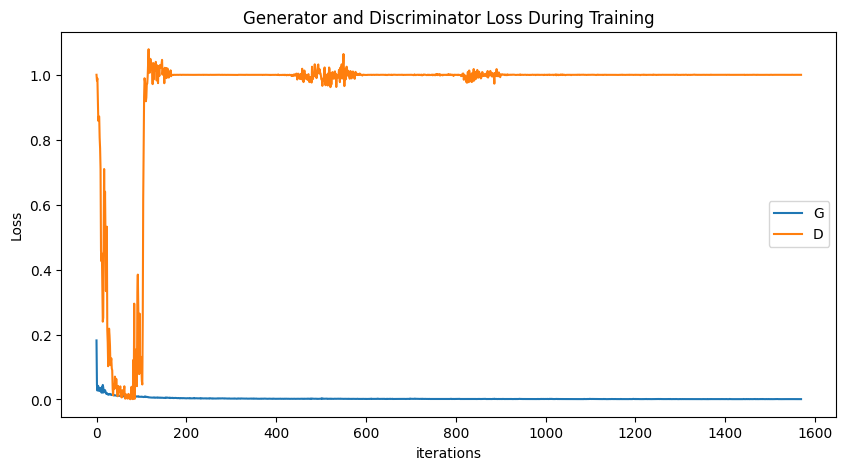

In [97]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig('{}/loss.png'.format(logfolder))
plt.show()